**Objective**: The main objective of the Stanford Open Policing Project is to collect, standardize, and release traffic stop and search data from various U.S. police departments. This dataset enables detailed analysis and understanding of racial and ethnic disparities in policing, as well as other issues surrounding police behavior and practices.

**Dataset Details**: The data generally includes information about:

*   Date and time of the stop
*   Location
*   Driver's race, gender, and age
*   Reason for the stop (e.g., speeding, equipment violation)
*   Reason for the stop (e.g., speeding, equipment violation)
*   Result of the stop (e.g., warning, citation, arrest)
*   Whether a search was conducted and if contraband was found


**Coverage**: The wesbite includes dataset covered 31 states, with data from dozens of individual departments. It's worth noting that the availability and granularity of the data can vary across states and departments, based on their respective data collection and reporting practices.

For this project, we chose San Diego dataset due to the Volume available and the variety of the recorded features.

In [2]:
!pip install dmba
!pip install pandas
!pip install dmba
!pip install sns
!pip install seaborn
!pip install plotly
!pip install scikit-learn

  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/7b/e5/83fcd7e9db036c179e0352bfcd20f81d728197a16f883e7b90307a88e65e/seaborn-0.13.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 4.5 MB/s eta 0:00:00a 0:00:01


In [16]:
!pip install plotly orca
!pip install --upgrade plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 26.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.6 MB/s eta 0:00:00
  Obtaining dependency information for cython>=0.29.21 from https://files.pythonhosted.org/packages/e2/18/ba1a01c0ed30b248878b98fcf0654141c1c0e476166b5dcb4d7c04214884/Cython-3.0.2-cp311-cp311-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for numexpr>=2.6.2 from https://files.pythonhosted.org/packages/53/41/10fe06719ea162b29cc1e8d2c65bfb9be9834b801e574efb769f1a24c77e/numexpr-2.8.7-cp311-cp311-macosx_10_9_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 42.2 MB/s eta 0:00:0000:0100:01
  Obtaining dependency information for msgpack from https://files.pythonhosted.org/packages/15/56/a677cd761a2cefb2e3ffe7e684633294dccb161d78e8ea6da9277e45b4a2/msgpack-1.0.7-cp311-cp311-macosx_10_9_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 41.6 MB/s eta 0:00:000

In [3]:
import pandas as pd


df = pd.read_csv('ca_san_diego_2020_04_01.csv')
#display(df)

print(df.columns)



#Checking Categories and categorical columns
# for col in ['subject_race',
#        'subject_sex','service_area','type', 'arrest_made', 'citation_issued',
#        'warning_issued', 'outcome', 'contraband_found', 'search_conducted',
#        'search_person', 'search_vehicle', 'search_basis','raw_subject_race_description','reason_for_stop','reason_for_search','raw_action_taken']:
#        print(col,df[col].unique(),sep=':')


# Dropping these columns as they don't have any relation with the dependent variables, also type column has just one value hence dropped
df = df.drop(['raw_row_number'],axis=1)

#Dropping these columns since they are not categorical, nor numeric also don't have a pattern among them. It's just plain text and we don't think any value can be obtained from them
df = df.drop(['reason_for_stop','reason_for_search','raw_action_taken'],axis =1) #Outcome variable is handled as seprate columns in dummies

#Setting NaN values to 0(false) assuming that since they are not true most probable outcome is false
df[['arrest_made','citation_issued','warning_issued','contraband_found','search_conducted','search_person','search_vehicle']] = df[['arrest_made','citation_issued','warning_issued','contraband_found','search_conducted','search_person','search_vehicle']].fillna(False)


#Binning Ages in terms of under age, adult and senior citizen
#print(df['subject_age'].max(),df['subject_age'].min())
bins = [0, 18, 60,100]
labels = ['under_age', 'adult', 'senior_citizen']
df['subject_age'] = pd.cut(df['subject_age'], bins,labels=labels)

#Converting to datetime and check for min,max date
df['datetime'] = df['date'] + ' ' + df['time']
df['date'] = pd.to_datetime(df['datetime'], format = '%Y-%m-%d %H:%M:%S')
df['datetime'] = pd.to_datetime(df['datetime'])

#Encode boolean values
#df = pd.get_dummies(df,columns = ['arrest_made', 'citation_issued', 'warning_issued', 'contraband_found', 'search_conducted', 'search_person', 'search_vehicle'])
df[['arrest_made', 'citation_issued', 'warning_issued', 'contraband_found', 'search_conducted', 'search_person', 'search_vehicle']] = df[['arrest_made', 'citation_issued', 'warning_issued', 'contraband_found', 'search_conducted', 'search_person', 'search_vehicle']].fillna(False).astype(int)

# Creat bins for time
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time
time_bins = [0, 6, 12,18,24]
time_labels = ['Night', 'Morning', 'Afternoon','Evening']
df['TimeOfDay'] = pd.cut(df['time'].apply(lambda x: x.hour), bins=time_bins, labels=time_labels, right=False)
df = df.drop(['time','date'],axis = 1)

eda_df = df.copy()


#Drop rows based on na if needed - outcome if na that means there is no dependent variable associated with it so no use in our model
#print(df['outcome'].value_counts(dropna=False)) #Check whether na is significant part of your data based
indexAge = df[ df['outcome'].isna() ].index
df.drop(indexAge , inplace=True)
#Wherever we have string value in service_area we are ignoring since it is supposed to be false - around 10k records have string values
mask = pd.to_numeric(df['service_area'], errors='coerce').notna()
#Use the mask to filter rows
df = df[mask]

df = df.drop(['type'],axis=1)

model_df = df.copy()

#Encode Categorical Data
df = pd.get_dummies(df,columns=['subject_race','subject_sex','search_basis','raw_subject_race_description','subject_age','TimeOfDay'])



Index(['raw_row_number', 'date', 'time', 'service_area', 'subject_age',
       'subject_race', 'subject_sex', 'type', 'arrest_made', 'citation_issued',
       'warning_issued', 'outcome', 'contraband_found', 'search_conducted',
       'search_person', 'search_vehicle', 'search_basis', 'reason_for_search',
       'reason_for_stop', 'raw_action_taken', 'raw_subject_race_description'],
      dtype='object')


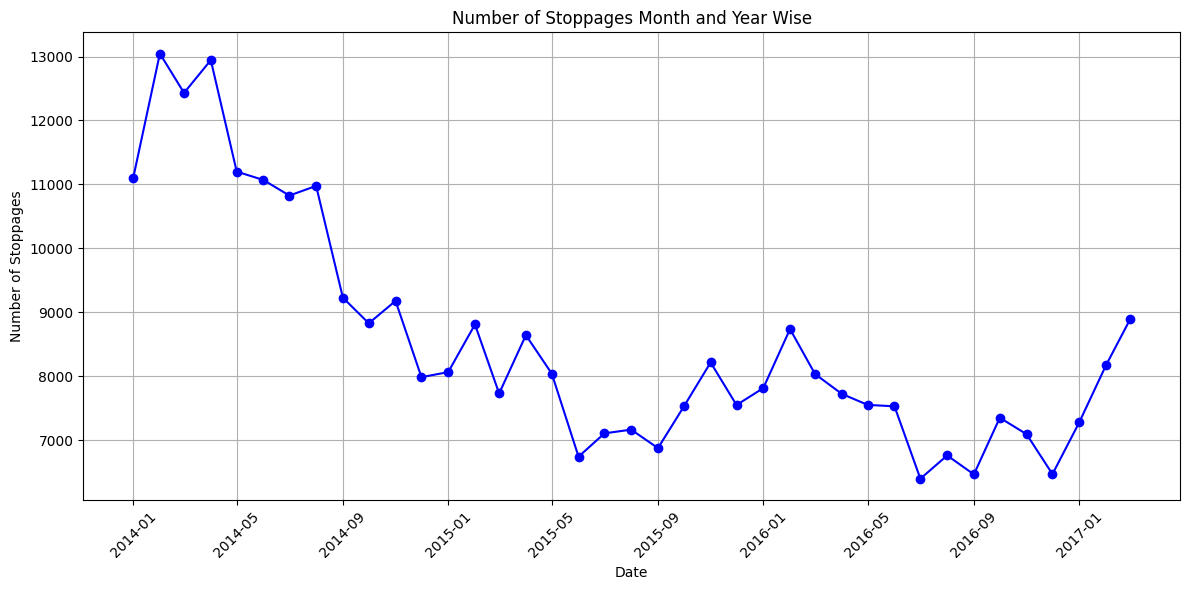

In [9]:
import matplotlib.pyplot as plt
# Make sure the 'datetime' column is in datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Extract the year and month from the 'datetime' column
df['Year'] = df['datetime'].dt.year
df['Month'] = df['datetime'].dt.month

# Group the data by year and month and count the number of stoppages
stoppages_by_month = df.groupby(['Year', 'Month']).size().reset_index(name='Stoppages')

# Create a line graph using matplotlib
plt.figure(figsize=(12, 6))
plt.plot(
    pd.to_datetime(stoppages_by_month[['Year', 'Month']].assign(day=1)),  # Year and month as a date
    stoppages_by_month['Stoppages'],
    marker='o',
    color='b',
)
plt.title('Number of Stoppages Month and Year Wise')
plt.xlabel('Date')
plt.ylabel('Number of Stoppages')
plt.xticks(rotation=45)
plt.grid(True)

# Show the graph
plt.tight_layout()
plt.savefig("Number_of_Stoppages_Month_and_Year_Wise.png")
plt.show()

In [21]:
import plotly.express as px

# Assuming you have a DataFrame 'df' with the relevant columns

# i) Male vs. Female (subject_sex_male)
gender_counts = df['subject_sex_male'].replace({0: 'Female', 1: 'Male'}).value_counts().reset_index()
gender_counts.columns = ['Gender', 'Count']

# ii) Age Groups (subject_age_adult, subject_age_under_age,subject_age_senior_citizen)
age_groups_counts = df[['subject_age_adult', 'subject_age_under_age','subject_age_senior_citizen']].sum().reset_index()
age_groups_counts.columns = ['Age Group', 'Count']

# iii) Race (subject_race)
race_counts = df[['subject_race_black', 'subject_race_hispanic', 'subject_race_other', 'subject_race_white','subject_race_asian/pacific islander']].sum().reset_index()
race_counts.columns = ['Race', 'Count']

# Create an interactive bar graph for each category
fig_gender = px.bar(gender_counts, x='Gender', y='Count', title='Driver Counts by Gender')
fig_age_groups = px.bar(age_groups_counts, x='Age Group', y='Count', title='Driver Counts by Age Group')
fig_race = px.bar(race_counts, x='Race', y='Count', title='Driver Counts by Race')

# Show the interactive graphs
fig_gender.show()
fig_age_groups.show()
fig_race.show()

In [19]:
# !pip install -U kaleido

In [6]:
subset_df = df[['subject_sex_male', 'arrest_made', 'citation_issued', 'warning_issued']]

# Group the data by 'subject_sex_male' and calculate the sum of each event type
grouped_data = subset_df.groupby('subject_sex_male').sum()
print(grouped_data)
# Calculate the percentage of each event type (arrests, citations, warnings) relative to the total for each gender
grouped_data_percentages = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100
print(grouped_data_percentages)

# Reset the index to make 'subject_sex_male' a column for Plotly
grouped_data_percentages.reset_index(inplace=True)

# Create an interactive bar chart using Plotly Express
fig = px.bar(
    grouped_data_percentages,
    x='subject_sex_male',
    y=['arrest_made', 'citation_issued', 'warning_issued'],
    color_discrete_sequence=['blue', 'orange', 'green','yellow'],
    labels={'value': 'Percentage (%)', 'subject_sex_male': 'Gender', 'variable': 'Event Type'},
    title='Percentage of Arrests, Citations, and Warnings by Gender',
)

# Customize the layout (optional)
fig.update_layout(
    xaxis=dict(tickvals=[0, 1], ticktext=['Female', 'Male']),
    xaxis_title=None,
    yaxis_title=None,
)

# Show the interactive chart
fig.show()


                  arrest_made  citation_issued  warning_issued
subject_sex_male                                              
False                    1056            78633           39678
True                     3647           135205           78543
                  arrest_made  citation_issued  warning_issued
subject_sex_male                                              
False                0.884667        65.874991       33.240343
True                 1.677591        62.193243       36.129166


   TimeOfDay subject_sex  search_conducted  total_search  %_search_time
0      Night      female               637          3138      20.299554
1      Night        male              2673         13095      20.412371
2    Morning      female               805          3138      25.653282
3    Morning        male              2738         13095      20.908744
4  Afternoon      female               803          3138      25.589547
5  Afternoon        male              3341         13095      25.513555
6    Evening      female               893          3138      28.457616
7    Evening        male              4343         13095      33.165330


Text(0.5, 1.0, 'Which time are drivers searched the most?')

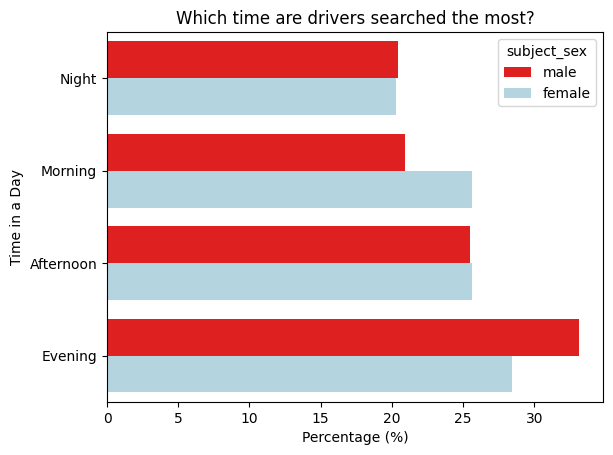

In [ ]:
time_search = eda_df.groupby(['TimeOfDay','subject_sex'])['search_conducted'].agg('sum')
time_search = time_search.reset_index()
time_search['total_search'] = time_search.groupby('subject_sex')['search_conducted'].transform('sum')
time_search['%_search_time'] = time_search['search_conducted']/time_search['total_search'] * 100
print(time_search)

sns.barplot(x='%_search_time', y='TimeOfDay',data=time_search , hue='subject_sex',\
            hue_order = ['male','female'],palette = {'male':'red','female':'lightblue'},orient='h')
# Set labels and title
plt.ylabel('Time in a Day')
plt.xlabel('Percentage (%)')
plt.title('Which time are drivers searched the most?')

  subject_sex    sum   count  percentage_search
0      female   3141  133968           2.344590
1        male  13107  248398           5.276613


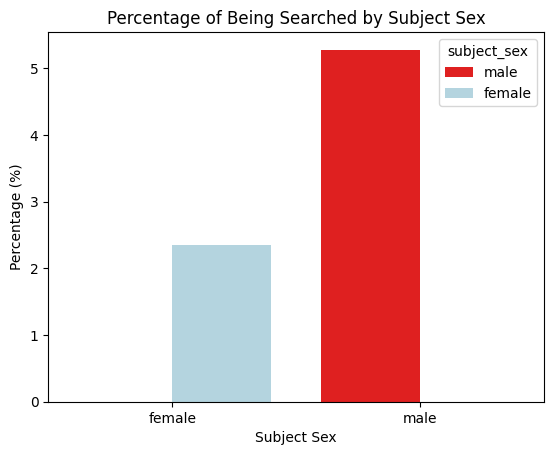

In [ ]:
sex_search = eda_df.groupby('subject_sex')['search_conducted'].agg(['sum','count'])
sex_search['percentage_search'] = sex_search['sum']/sex_search['count'] * 100
print(sex_search.reset_index())

# Plug data in to plot
sns.barplot(data=sex_search.reset_index(), x='subject_sex', y='percentage_search', hue='subject_sex',\
            hue_order = ['male','female'],palette = {'male':'red','female':'lightblue'})

# Set labels and title
plt.xlabel('Subject Sex')
plt.ylabel('Percentage (%)')
plt.title('Percentage of Being Searched by Subject Sex')

# Display the plot
plt.show()

  subject_sex  search_conducted   sum  count  contraband_percentage
0      female                 1   269   3141               8.564152
1        male                 1  1276  13107               9.735256


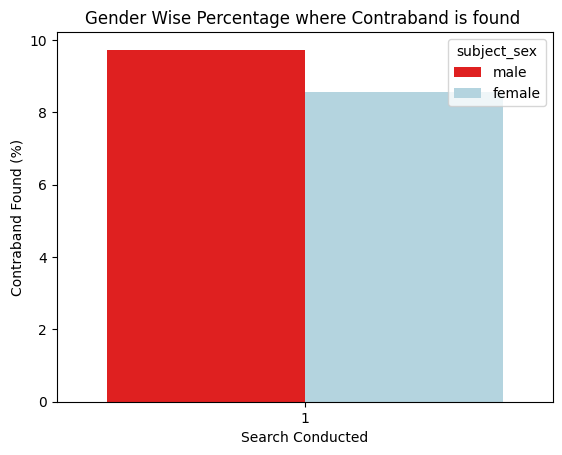

In [ ]:
eda_df['contraband_found'].fillna(0,inplace=True)
group = eda_df[eda_df['search_conducted']==True].groupby(['subject_sex','search_conducted'])['contraband_found'].agg(['sum','count'])
group['contraband_percentage'] = group['sum']/group['count'] * 100
print(group.reset_index())


# Plug data in to plot
sns.barplot(data=group.reset_index(), x='search_conducted', y='contraband_percentage', hue='subject_sex',\
            hue_order = ['male','female'],palette = {'male':'red','female':'lightblue'})

# Set labels and title
plt.xlabel('Search Conducted')
plt.ylabel('Contraband Found (%)')
plt.title('Gender Wise Percentage where Contraband is found ')

# Display the plot
plt.show()

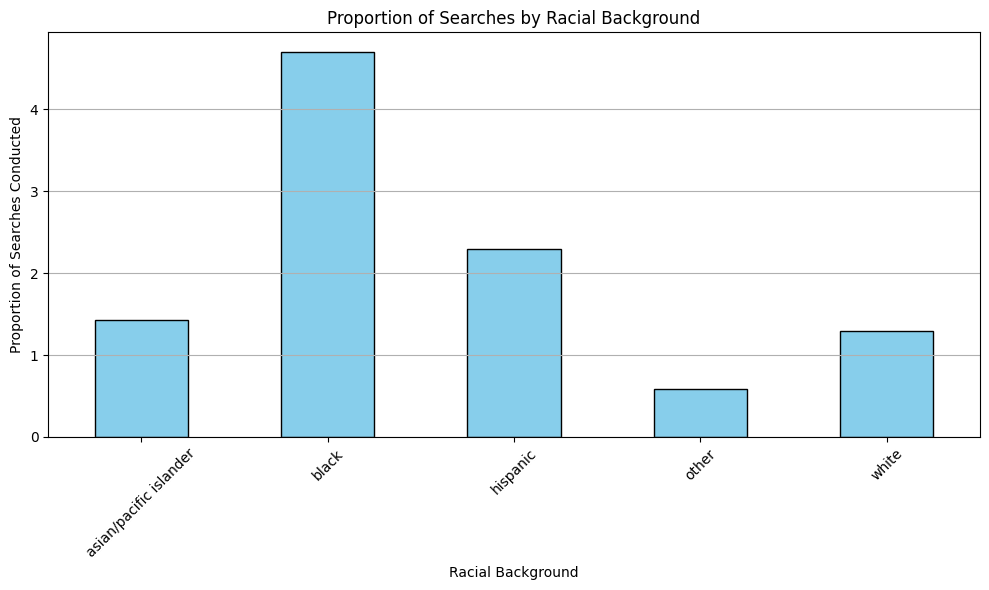

In [ ]:
# Group by the racial background
grouped = eda_df.groupby('subject_race')['search_person'].agg(['sum', 'count'])

# Calculate the proportion of searches for each racial background
grouped['proportion'] = (grouped['sum'] / grouped['count'])*100

# Create a bar chart of the proportions
plt.figure(figsize=(10,6))
grouped['proportion'].plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Proportion of Searches by Racial Background')
plt.xlabel('Racial Background')
plt.ylabel('Proportion of Searches Conducted')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
import plotly.express as px

# Extract required columns
subset_df = eda_df[['subject_race', 'arrest_made', 'citation_issued', 'warning_issued']]

# Group by 'subject_race' and calculate the sum of each event type
grouped_data = subset_df.groupby('subject_race').sum()
print(grouped_data)

# Calculate the percentage of each event type (arrests, citations, warnings) relative to the total for each race
grouped_data_percentages = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100
print(grouped_data_percentages)

# Reset the index to make 'subject_race' a column for Plotly
grouped_data_percentages.reset_index(inplace=True)

# Create an interactive bar chart using Plotly Express
fig = px.bar(
    grouped_data_percentages,
    x='subject_race',
    y=['arrest_made', 'citation_issued', 'warning_issued'],
    title='Percentage of Arrests, Citations, and Warnings by Race',
    labels={'value': 'Percentage (%)', 'subject_race': 'Race', 'variable': 'Event Type'},
    color_discrete_sequence=['blue', 'orange', 'green'],  # Assuming you have 3 types. Adjust if more.
)

# You can further customize the layout if needed. Here's a basic one for demonstration.
fig.update_layout(
    xaxis_title=None,
    yaxis_title=None,
)

# Show the interactive chart
fig.show()

                        arrest_made  citation_issued  warning_issued
subject_race                                                        
asian/pacific islander          309            17896           11985
black                           857            20728           16780
hispanic                       1714            67787           33863
other                           160            17359            7139
white                          1771            96631           50670
                        arrest_made  citation_issued  warning_issued
subject_race                                                        
asian/pacific islander     1.023518        59.277907       39.698576
black                      2.233807        54.028411       43.737782
hispanic                   1.658218        65.580860       32.760923
other                      0.648877        70.399059       28.952064
white                      1.188017        64.821697       33.990287


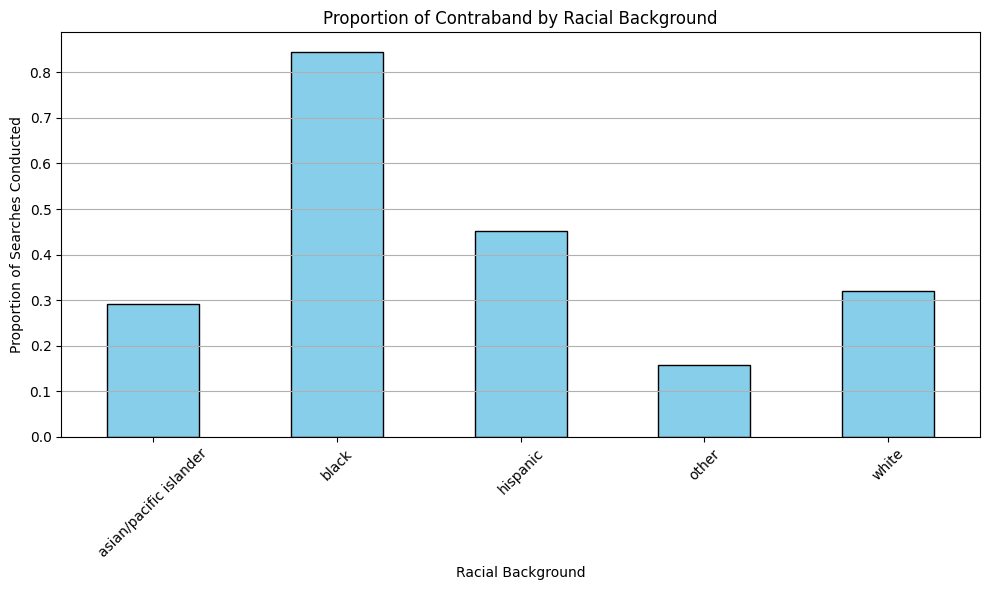

In [ ]:
# Group by the racial background
grouped = eda_df.groupby('subject_race')['contraband_found'].agg(['sum', 'count'])

# Calculate the proportion of searches for each racial background
grouped['proportion'] = (grouped['sum'] / grouped['count'])*100

# Create a bar chart of the proportions
plt.figure(figsize=(10,6))
grouped['proportion'].plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Proportion of Contraband by Racial Background')
plt.xlabel('Racial Background')
plt.ylabel('Proportion of Searches Conducted')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Display the plot
plt.tight_layout()
plt.show()

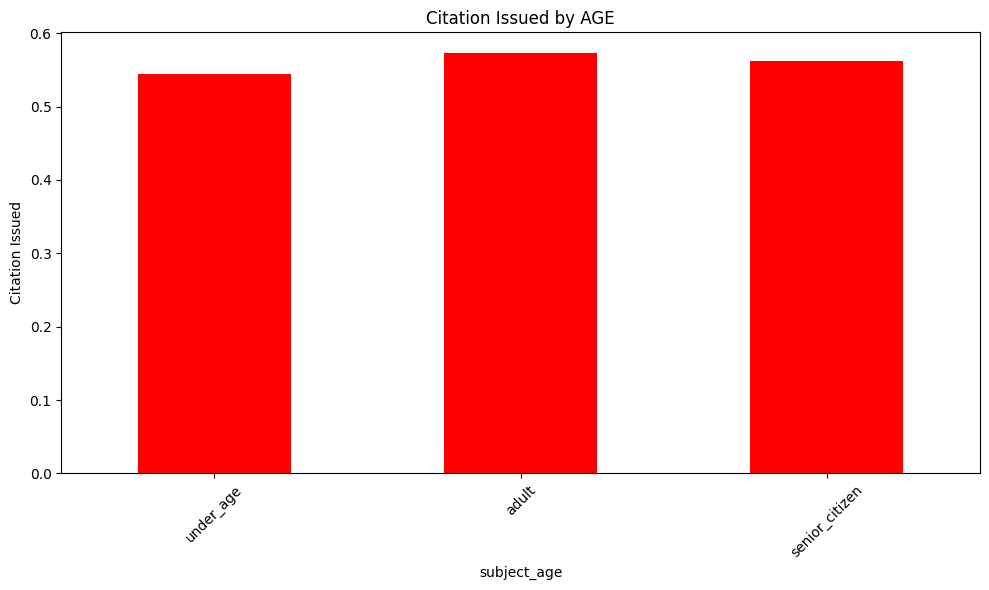

In [ ]:
# Calculate the arrest rate for each age group
grouped = eda_df.groupby('subject_age')['citation_issued'].agg(['sum', 'count'])
grouped['citation_issued'] = grouped['sum'] / grouped['count']

# Plot the arrest rates
plt.figure(figsize=(10,6))
grouped['citation_issued'].plot(kind='bar', color='red')
plt.ylabel('Citation Issued')
plt.title('Citation Issued by AGE')
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

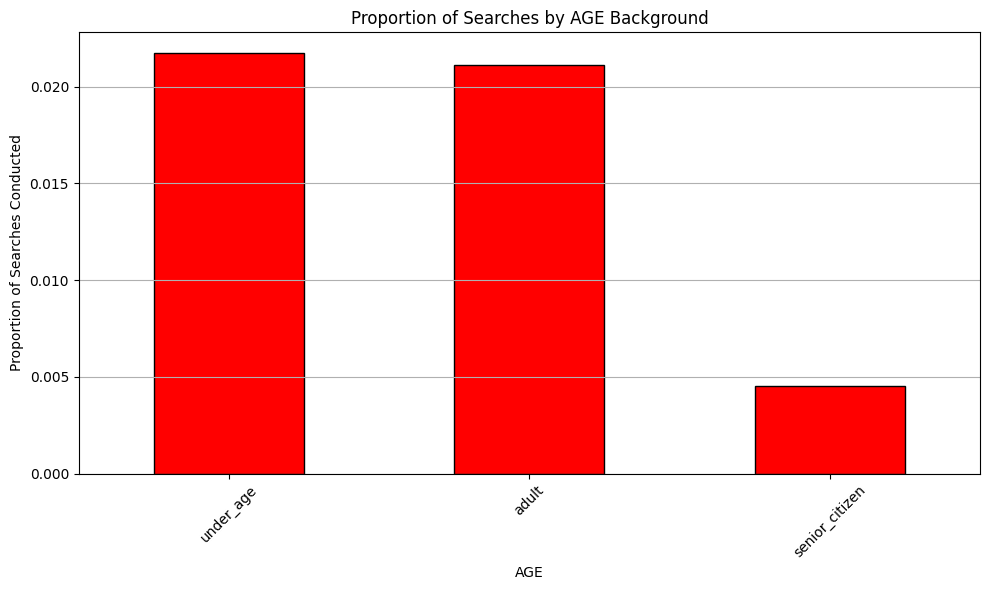

In [ ]:
# Group by the AGE background
grouped = eda_df.groupby('subject_age')['search_person'].agg(['sum', 'count'])

# Calculate the proportion of searches for each AGE GROUP
grouped['proportion'] = grouped['sum'] / grouped['count']

# Create a bar chart of the proportions
plt.figure(figsize=(10,6))
grouped['proportion'].plot(kind='bar', color='red', edgecolor='black')

# Add labels and title
plt.title('Proportion of Searches by AGE Background')
plt.xlabel('AGE')
plt.ylabel('Proportion of Searches Conducted')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Display the plot
plt.tight_layout()
plt.show()

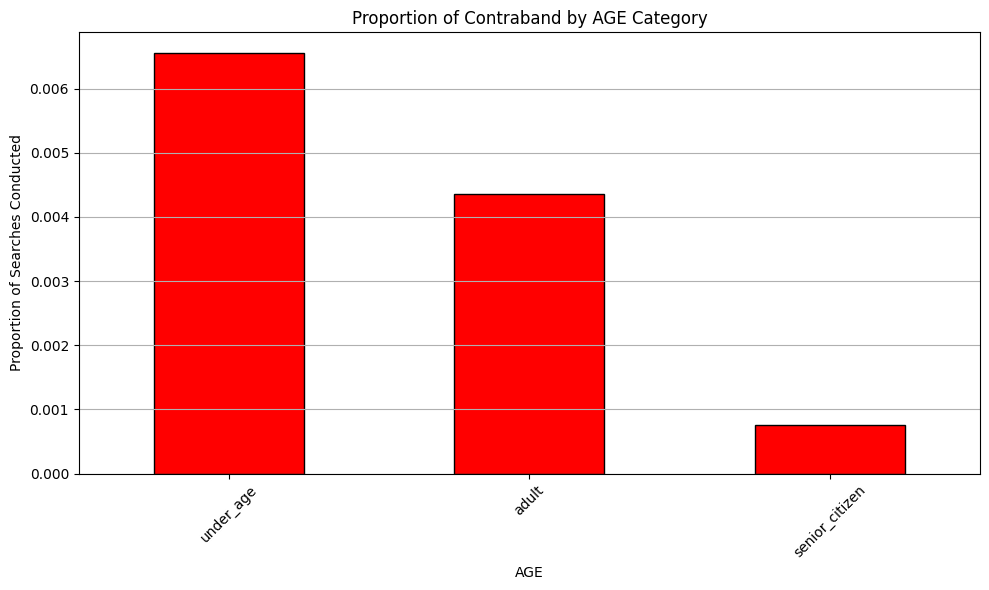

In [ ]:
# Group by the AGE background
grouped = eda_df.groupby('subject_age')['contraband_found'].agg(['sum', 'count'])

# Calculate the proportion of searches for each AGE Category
grouped['proportion'] = grouped['sum'] / grouped['count']

# Create a bar chart of the proportions
plt.figure(figsize=(10,6))
grouped['proportion'].plot(kind='bar', color='red', edgecolor='black')

# Add labels and title
plt.title('Proportion of Contraband by AGE Category')
plt.xlabel('AGE')
plt.ylabel('Proportion of Searches Conducted')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
from pathlib import Path

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
import dmba
from dmba import plotDecisionTree, classificationSummary, regressionSummary, gainsChart, liftChart
from dmba.metric import AIC_score

%matplotlib inline

                       feature  importance       std
9            TimeOfDay_Evening    0.101579  0.038262
7            TimeOfDay_Morning    0.096413  0.042561
8          TimeOfDay_Afternoon    0.093521  0.040757
2             subject_sex_male    0.082049  0.036663
0            subject_age_adult    0.054679  0.023354
4        subject_race_hispanic    0.050098  0.019611
6           subject_race_white    0.048020  0.017307
3           subject_race_black    0.046654  0.017318
1   subject_age_senior_citizen    0.046642  0.018748
28            service_area_830    0.039434  0.009626
18            service_area_510    0.030491  0.010115
5           subject_race_other    0.026697  0.009806
17            service_area_440    0.025505  0.010017
16            service_area_430    0.022035  0.006819
10            service_area_120    0.021729  0.007923
27            service_area_820    0.019607  0.007124
19            service_area_520    0.018674  0.007141
20            service_area_530    0.017874  0.

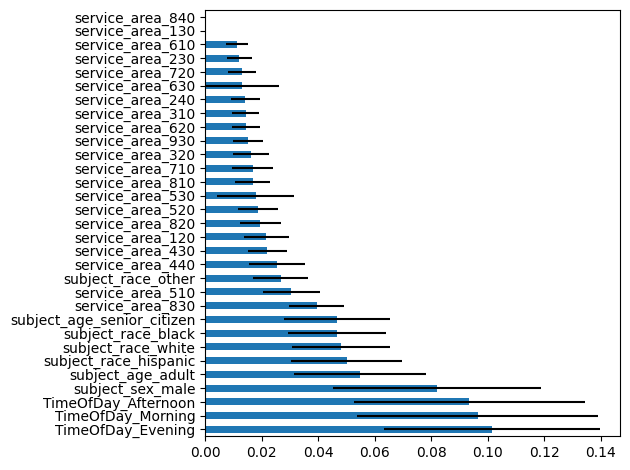

In [ ]:
predictors = [ 'subject_age', 'subject_sex', 'subject_race','TimeOfDay','service_area']
#very weird but when put in contraband found and search conducted, it changed the importance of the RF (white is now more important than black etc)
outcome = 'arrest_made' #define the outcome variable

# partition data
X = pd.get_dummies(model_df[predictors], drop_first=True) #convert categorical variables into dummy

y = model_df[outcome]


train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

rf = RandomForestClassifier(n_estimators=100, random_state=1)
rf.fit(train_X, train_y)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

df1 = pd.DataFrame({'feature': train_X.columns, 'importance': importances, 'std': std})
df1 = df1.sort_values('importance', ascending= False)
print(df1)

ax = df1.plot(kind='barh', xerr='std', x='feature', legend=False)
ax.set_ylabel('')

plt.tight_layout()
plt.show()

In [ ]:
classificationSummary(valid_y, rf.predict(valid_X))

Confusion Matrix (Accuracy 0.9856)

       Prediction
Actual      0      1
     0 131705      2
     1   1919      0


The black lines on the bars represent the error of the feature importance. Specifically, they are showing the standard deviation of the importance values across all the trees in the random forest. A longer black line means there's a larger variance in the importance of that feature across the individual trees in the forest. This gives you an idea of the stability or consistency of the importance ranking for that feature. If the black bar is short, it suggests that the importance of that feature is fairly consistent across all the trees in the forest.

In [ ]:
print("Random Forest Report Without Upsampling:")
print(classification_report(valid_y, rf.predict(valid_X)))
print("accuracy:",accuracy_score(valid_y,rf.predict(valid_X)))

Random Forest Report Without Upsampling:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    131707
           1       0.00      0.00      0.00      1919

    accuracy                           0.99    133626
   macro avg       0.49      0.50      0.50    133626
weighted avg       0.97      0.99      0.98    133626

accuracy: 0.9856240551988386


In [ ]:
# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns).transpose())
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

intercept  -4.659609510996149
       subject_age_adult  subject_age_senior_citizen  subject_sex_male  \
coeff           0.668029                   -0.161947           0.49667   

       subject_race_black  subject_race_hispanic  subject_race_other  \
coeff             0.44921               0.349022           -0.384952   

       subject_race_white  TimeOfDay_Morning  TimeOfDay_Afternoon  \
coeff            0.215573          -1.343092            -1.074183   

       TimeOfDay_Evening  ...  service_area_610  service_area_620  \
coeff          -0.586643  ...         -0.128814          0.178616   

       service_area_630  service_area_710  service_area_720  service_area_810  \
coeff          1.092998         -0.579949           -0.0818          0.186999   

       service_area_820  service_area_830  service_area_840  service_area_930  
coeff          0.374848          0.665128         -1.714178         -0.524339  

[1 rows x 31 columns]
AIC -187727.11233959172


In [ ]:
classificationSummary(train_y, logit_reg.predict(train_X))
classificationSummary(valid_y, logit_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.9861)

       Prediction
Actual      0      1
     0 197653      0
     1   2784      0
Confusion Matrix (Accuracy 0.9856)

       Prediction
Actual      0      1
     0 131707      0
     1   1919      0


In [ ]:
from sklearn.metrics import classification_report, accuracy_score
print("Logitisc Regression Report without Upsampling:")

print(classification_report(valid_y, logit_reg.predict(valid_X)))
print("accuracy:",accuracy_score(valid_y,logit_reg.predict(valid_X)))

Logitisc Regression Report without Upsampling:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       0.99      1.00      0.99    131707
           1       0.00      0.00      0.00      1919

    accuracy                           0.99    133626
   macro avg       0.49      0.50      0.50    133626
weighted avg       0.97      0.99      0.98    133626

accuracy: 0.9856390223459507


Testing Imbalance-Fixed

In [ ]:
from sklearn.utils import resample

df_majority = model_df[model_df.arrest_made==0]
df_minority = model_df[model_df.arrest_made==1]


# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=364265,    # to match majority class
                                 random_state=123) # reproducible results

df_upsampled = pd.concat([df_majority, df_minority_upsampled])



# partition data
X = pd.get_dummies(df_upsampled[predictors], drop_first=True)

y = df_upsampled[outcome]


train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg_upsampled = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg_upsampled.fit(train_X, train_y)

print('intercept ', logit_reg_upsampled.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg_upsampled.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg_upsampled.predict(valid_X), df = len(train_X.columns) + 1))

intercept  -0.36296990016451536
       subject_age_adult  subject_age_senior_citizen  subject_sex_male  \
coeff            0.67093                   -0.108027          0.505879   

       subject_race_black  subject_race_hispanic  subject_race_other  \
coeff            0.544166               0.314957           -0.472379   

       subject_race_white  TimeOfDay_Morning  TimeOfDay_Afternoon  \
coeff            0.216069          -1.344779            -1.146106   

       TimeOfDay_Evening  ...  service_area_610  service_area_620  \
coeff          -0.585047  ...         -0.082316          0.270907   

       service_area_630  service_area_710  service_area_720  service_area_810  \
coeff          0.569145         -0.452898          0.098692          0.188164   

       service_area_820  service_area_830  service_area_840  service_area_930  
coeff           0.50886          0.769121         -4.142138         -0.545082  

[1 rows x 31 columns]

AIC 482110.53588084347


In [ ]:
classificationSummary(valid_y, logit_reg_upsampled.predict(valid_X))

Confusion Matrix (Accuracy 0.6673)

       Prediction
Actual      0      1
     0  82066  49532
     1  42780 103072


In [ ]:
from sklearn.metrics import classification_report, accuracy_score
print("Logitisc Regression Report: with UpSampling")
print(classification_report(valid_y, logit_reg_upsampled.predict(valid_X)))
print("accuracy:",accuracy_score(valid_y,logit_reg_upsampled.predict(valid_X)))

Logitisc Regression Report: with UpSampling
              precision    recall  f1-score   support

           0       0.66      0.62      0.64    131598
           1       0.68      0.71      0.69    145852

    accuracy                           0.67    277450
   macro avg       0.67      0.67      0.67    277450
weighted avg       0.67      0.67      0.67    277450

accuracy: 0.6672841953505136


                       feature  importance       std
9            TimeOfDay_Evening    0.101579  0.009932
7            TimeOfDay_Morning    0.096413  0.032972
8          TimeOfDay_Afternoon    0.093521  0.036727
2             subject_sex_male    0.082049  0.009605
0            subject_age_adult    0.054679  0.010717
4        subject_race_hispanic    0.050098  0.008101
6           subject_race_white    0.048020  0.008445
3           subject_race_black    0.046654  0.006879
1   subject_age_senior_citizen    0.046642  0.011024
28            service_area_830    0.039434  0.006314
18            service_area_510    0.030491  0.005451
5           subject_race_other    0.026697  0.005828
17            service_area_440    0.025505  0.003864
16            service_area_430    0.022035  0.003966
10            service_area_120    0.021729  0.003131
27            service_area_820    0.019607  0.002765
19            service_area_520    0.018674  0.003022
20            service_area_530    0.017874  0.

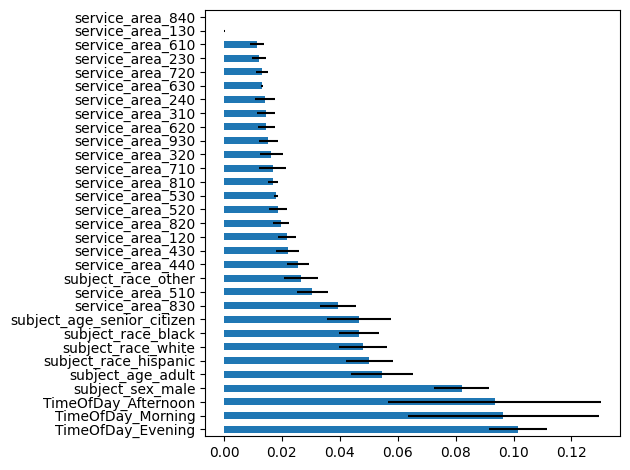

Confusion Matrix (Accuracy 0.6965)

       Prediction
Actual      0      1
     0 123165  74597
     1  51705 166708
Confusion Matrix (Accuracy 0.6938)

       Prediction
Actual      0      1
     0  81655  49943
     1  35010 110842


In [ ]:
rf_upsampled = RandomForestClassifier(n_estimators=100, random_state=1)
rf_upsampled.fit(train_X, train_y)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_upsampled.estimators_], axis=0)

df = pd.DataFrame({'feature': train_X.columns, 'importance': importances, 'std': std})
df = df.sort_values('importance', ascending= False)
print(df)

ax = df.plot(kind='barh', xerr='std', x='feature', legend=False)
ax.set_ylabel('')

plt.tight_layout()
plt.show()

classificationSummary(train_y, rf_upsampled.predict(train_X))
classificationSummary(valid_y, rf_upsampled.predict(valid_X))

In [ ]:
print("Random Forest Report With Upsampling:")

print(classification_report(valid_y, rf_upsampled.predict(valid_X)))
print("accuracy:",accuracy_score(valid_y,rf_upsampled.predict(valid_X)))

Random Forest Report With Upsampling:
              precision    recall  f1-score   support

           0       0.70      0.62      0.66    131598
           1       0.69      0.76      0.72    145852

    accuracy                           0.69    277450
   macro avg       0.69      0.69      0.69    277450
weighted avg       0.69      0.69      0.69    277450

accuracy: 0.6938078933141106
